In [1]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [2]:
loader = PyPDFLoader("EV battery.pdf")
documents = loader.load()

In [3]:
print(len(documents))

25


In [4]:
from langchain.embeddings import HuggingFaceEmbeddings

embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")

C:\Users\bhave\AppData\Local\Temp\ipykernel_9412\1250464492.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")
c:\Users\bhave\anaconda3\envs\serach\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## setup the API Key for LLM

In [5]:
from groq import Groq
from langchain_groq import ChatGroq

In [6]:
import os

groq_api_key = os.getenv("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")

## Perform Semantic Chunking

In [7]:
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

semantic_chunker = SemanticChunker(embed_model, breakpoint_threshold_type="percentile")

In [8]:
semantic_chunks = semantic_chunker.create_documents([d.page_content for d in documents])

In [9]:
for semantic_chunk in semantic_chunks:
  if "Effect of Pre-training Tasks" in semantic_chunk.page_content:
    print(semantic_chunk.page_content)
    print(len(semantic_chunk.page_content))

In [20]:
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

# Example: Assuming `semantic_chunks` is a list of documents and `embed_model` is your embedding function
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create FAISS vectorstore
semantic_chunk_vectorstore = FAISS.from_documents(semantic_chunks, embedding=embedding_model)

# Instantiate Retrieval Step
semantic_chunk_retriever = semantic_chunk_vectorstore.as_retriever(search_kwargs={"k": 1})

# Query the retriever
response = semantic_chunk_retriever.invoke("ABrief Introduction of Battery Electric Vehicles (BEVs)")
print(response)


[Document(id='c48777ef-a564-425c-92b8-7abe3cb10710', metadata={}, page_content='Battery Electric Vehicles (BEVs)\nAhmad Faraz, A. Ambikapathy, Saravanan Thangavel, K. Logavani,\nand G. Arun Prasad\n1 Introduction\n1.1 A Brief Introduction of Battery Electric V ehicles (BEVs)\nA battery electric vehicle (BEV) is basically an electric vehicle (EV) that solitary\nconsumes compound energy to run which is put away in rechargeable battery packs,\nwith no other source (e.g., hydrogen energy component, an internal combustion\nengine, and so forth). BEVs utilize electric engine and system instead of an internal\ncombustion engine (ICEs) for propulsion. They get all force from battery packs and\nuse it to run the engine which further aides in driving the wheels. They are otherwise\ncalled unadulterated electric vehicles or just electric vehicles or all-electric vehicle. Battery electric vehicles (BEVs) incorporate different sorts of vehicles, for example,\ncruisers, bikes, skateboards, railcars,

In [21]:
from langchain_core.prompts import ChatPromptTemplate

rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

In [22]:
# Define the userdata dictionary with your API key
userdata = {
    "GROQ_API_KEY": "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"
}

# Initialize the chat model
chat_model = ChatGroq(
    temperature=0,
    model_name="mixtral-8x7b-32768",
    api_key=userdata.get("GROQ_API_KEY")
)

## RAG Pipeline Utilizing Semantic Chunking

In [23]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

semantic_rag_chain = (
    {"context" : semantic_chunk_retriever, "question" : RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

In [24]:
semantic_rag_chain.invoke("ABrief Introduction of Battery Electric Vehicles (BEVs)")

'Battery Electric Vehicles (BEVs) are electric vehicles that solely consume compound energy stored in rechargeable battery packs, with no other source of power such as hydrogen energy components or internal combustion engines. They use electric engines and systems instead of internal combustion engines (ICEs) for propulsion. BEVs get all their power from battery packs and use it to run the engine, which further aids in driving the wheels. They are also known as pure electric vehicles or just electric vehicles or all-electric vehicles. BEVs include various types of vehicles such as cruisers, bikes, skateboards, railcars, watercraft, forklifts, transports, trucks, and other vehicles. BEVs are simple and easy to operate compared to traditional internal combustion engine (ICE) vehicles.'

In [28]:
import pandas as pd
import time
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from transformers import AutoTokenizer
from langchain_groq import ChatGroq

# Initialize tokenizer for token count analysis (optional)
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

# Initialize embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create FAISS vectorstore
semantic_chunk_vectorstore = FAISS.from_documents(semantic_chunks, embedding=embedding_model)

# Instantiate retriever
semantic_chunk_retriever = semantic_chunk_vectorstore.as_retriever(search_kwargs={"k": 1})

# Define the RAG prompt
rag_template = """\
Use the following context to answer the user's query. If you cannot answer, please respond with 'I don't know'.

User's Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(rag_template)

# Define API Key
userdata = {"GROQ_API_KEY": "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"}

# Initialize Chat Model
chat_model = ChatGroq(
    temperature=0,
    model_name="mixtral-8x7b-32768",
    api_key=userdata.get("GROQ_API_KEY")
)

# Create RAG Chain
semantic_rag_chain = (
    {"context": semantic_chunk_retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | chat_model
    | StrOutputParser()
)

# List to store results
results = []

# List of test queries
queries = [
    "A Brief Introduction of Battery Electric Vehicles (BEVs)",
    "Explain the working principle of a transformer",
    "What are the benefits of solar energy?"
]

# Run RAG pipeline and collect metrics
for query in queries:
    start_time = time.time()
    
    # Get response
    response = semantic_rag_chain.invoke(query)
    
    # Retrieve context
    retrieved_chunks = semantic_chunk_retriever.invoke(query)
    retrieved_context = retrieved_chunks[0].page_content if retrieved_chunks else "No Context Retrieved"
    
    end_time = time.time()
    
    # Calculate token counts
    query_tokens = len(tokenizer.tokenize(query))
    context_tokens = len(tokenizer.tokenize(retrieved_context))
    response_tokens = len(tokenizer.tokenize(response))
    
    # Store results
    results.append({
        "Query": query,
        "Retrieved Context": retrieved_context,
        "Response": response,
        "Query Tokens": query_tokens,
        "Context Tokens": context_tokens,
        "Response Tokens": response_tokens,
        "Retrieval Time (s)": round(end_time - start_time, 3)
    })

# Create DataFrame
df = pd.DataFrame(results)

# Display DataFrame
print(df)


Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors


                                               Query  \
0  A Brief Introduction of Battery Electric Vehic...   
1     Explain the working principle of a transformer   
2             What are the benefits of solar energy?   

                                   Retrieved Context  \
0  Battery Electric Vehicles (BEVs)\nAhmad Faraz,...   
1  Fig. 10 Anatomy of Rimac Concept One\n5 Workin...   
2  Battery Electric Vehicles (BEVs) 159\n8.7 Bett...   

                                            Response  Query Tokens  \
0  Battery Electric Vehicles (BEVs) are a type of...            11   
1  Based on the provided context, I cannot find s...             8   
2  Solar energy can benefit the use of battery el...             8   

   Context Tokens  Response Tokens  Retrieval Time (s)  
0             249              158               0.693  
1             176              228               0.814  
2             532              148               0.622  


                                               Query  \
0  A Brief Introduction of Battery Electric Vehic...   
1     Explain the working principle of a transformer   
2             What are the benefits of solar energy?   

                                   Retrieved Context  \
0  Battery Electric Vehicles (BEVs)\nAhmad Faraz,...   
1  Fig. 10 Anatomy of Rimac Concept One\n5 Workin...   
2  Battery Electric Vehicles (BEVs) 159\n8.7 Bett...   

                                            Response  Query Tokens  \
0  Battery Electric Vehicles (BEVs) are a type of...            11   
1  Based on the provided context, I cannot find s...             8   
2  Solar energy can benefit the use of battery el...             8   

   Context Tokens  Response Tokens  Retrieval Time (s)  
0             249              158               0.693  
1             176              228               0.814  
2             532              148               0.622  


<Figure size 800x500 with 0 Axes>

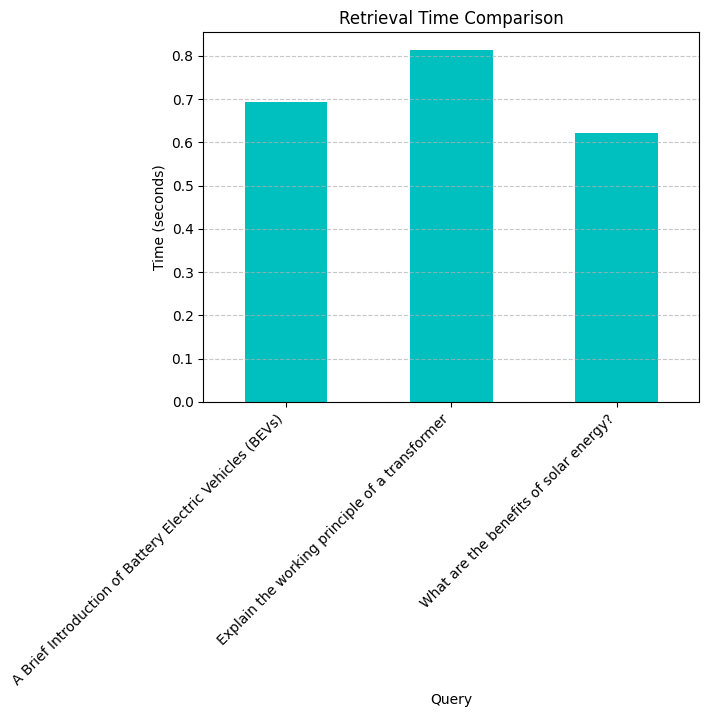

<Figure size 1000x500 with 0 Axes>

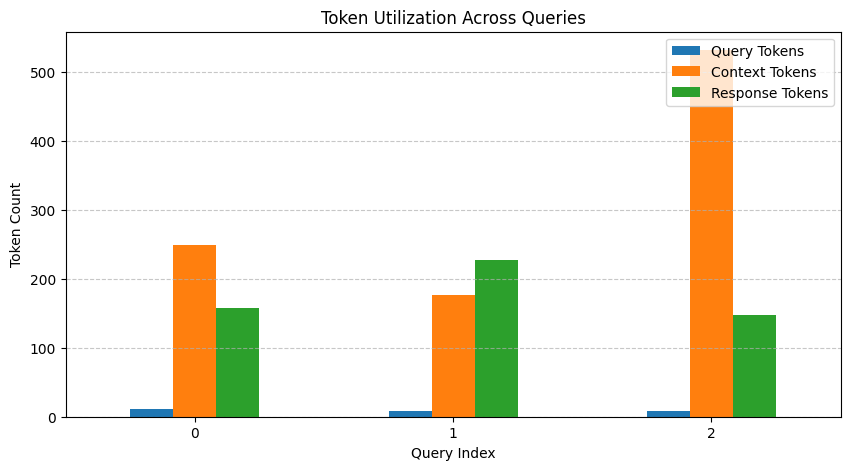

In [30]:
import matplotlib.pyplot as plt

# Display top results
print(df.head())

# Enable inline plotting (for Jupyter Notebooks)
%matplotlib inline  

# Plot Retrieval Time Comparison
plt.figure(figsize=(8, 5))
df.plot(x="Query", y="Retrieval Time (s)", kind="bar", legend=False, color="c")
plt.title("Retrieval Time Comparison")
plt.xlabel("Query")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=45, ha="right")  # Rotate query labels for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Plot Token Utilization Comparison
plt.figure(figsize=(10, 5))
df[["Query Tokens", "Context Tokens", "Response Tokens"]].plot(kind="bar", figsize=(10, 5))
plt.title("Token Utilization Across Queries")
plt.xlabel("Query Index")
plt.ylabel("Token Count")
plt.xticks(rotation=0)  # Keep index labels readable
plt.legend(loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
